In [1]:
from stacked_mnist import *
from verification_net import VerificationNet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from autoencoder import Autoencoder
from util import *

In [2]:
# GLOBALS
BATCH_SIZE = 1024
EPOCHS = 15
NUM_CHANNELS = 1


In [3]:
data = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)

train_dataset = data.get_full_data_set(training=True)
test_dataset = data.get_full_data_set(training=False)

In [4]:
class StackedMnistDataset(Dataset):
    def __init__(self, data):
        self.X = torch.from_numpy(data[0]).float()
        self.y = torch.from_numpy(data[1]).float()
        # turn them into long tensors
        self.y = self.y.long()
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
stacked_mnist_train = StackedMnistDataset(train_dataset)
stacked_mnist_test = StackedMnistDataset(test_dataset)

train_loader = DataLoader(stacked_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(stacked_mnist_test, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
for x, y in train_loader:
    # reshape to (batch_size, num_channels, height, width)
    #x = x.reshape(-1, 3, 28, 28)
    print(x.shape)
    print(y.shape)
    break

torch.Size([1024, 28, 28, 3])
torch.Size([1024])


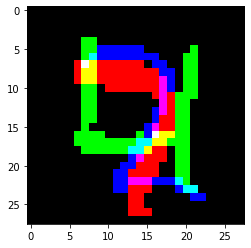

In [7]:
#plt.imshow(next(iter(train_loader))[0][3])
plt.imshow(next(iter(train_loader))[0][0])

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
model = Autoencoder(NUM_CHANNELS)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.to(device)

In [ ]:
def train(epochs=EPOCHS, force_retrain=False):

    # try to load the model if it exists and force_retrain is False
    if not force_retrain:
        try:
            checkpoint = torch.load("./models/stacked_gen_autoencoder.pth")
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            start_epoch = checkpoint["epoch"] + 1
            print("Loaded checkpoint from epoch", start_epoch)
        except:
            start_epoch = 0
            print("Starting from scratch")
    else:
        start_epoch = 0
        print("Starting from scratch (forced retrain)")

    # train the model
    outputs = []
    model.train()
    for epoch in range(start_epoch, epochs):
        for im, _ in train_loader:
            num_channels = im.shape[-1]
            im = im.reshape(-1, num_channels, 28, 28)
            im = im.to(device)
            # ===================forward=====================
            output = model(im)
            output = output.squeeze().reshape(-1, num_channels, 28, 28)
            loss = criterion(output, im)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, EPOCHS, loss.item()))
        outputs.append((epoch, im, output))

    # save the model
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, "./models/stacked_gen_autoencoder.pth")

    return outputs

In [ ]:
EPOCHS = 30
train_outputs = train(epochs=EPOCHS, force_retrain=True)

Loaded checkpoint from epoch 15
epoch [16/100], loss:0.1517
epoch [17/100], loss:0.1503
epoch [18/100], loss:0.1498
epoch [19/100], loss:0.1490
epoch [20/100], loss:0.1496
epoch [21/100], loss:0.1480
epoch [22/100], loss:0.1440
epoch [23/100], loss:0.1449
epoch [24/100], loss:0.1426
epoch [25/100], loss:0.1420
epoch [26/100], loss:0.1435
epoch [27/100], loss:0.1447
epoch [28/100], loss:0.1450
epoch [29/100], loss:0.1431
epoch [30/100], loss:0.1431
epoch [31/100], loss:0.1405
epoch [32/100], loss:0.1409
epoch [33/100], loss:0.1437
epoch [34/100], loss:0.1421
epoch [35/100], loss:0.1413
epoch [36/100], loss:0.1398
epoch [37/100], loss:0.1398
epoch [38/100], loss:0.1397
epoch [39/100], loss:0.1398
epoch [40/100], loss:0.1382
epoch [41/100], loss:0.1389
epoch [42/100], loss:0.1409
epoch [43/100], loss:0.1389
epoch [44/100], loss:0.1404
epoch [45/100], loss:0.1396
epoch [46/100], loss:0.1406
epoch [47/100], loss:0.1359
epoch [48/100], loss:0.1393
epoch [49/100], loss:0.1381
epoch [50/100], 

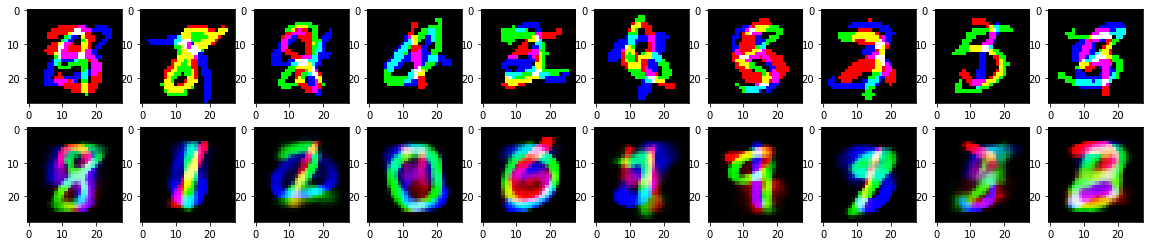

In [ ]:
#plt.imshow(train_outputs[0][1][3].reshape(28, 28, 3).detach().cpu().numpy())
imgs = train_outputs[0][1].reshape(-1, 28, 28, 3).detach().cpu().numpy()
recon = train_outputs[80][2].reshape(-1, 28, 28, 3).detach().cpu().numpy()
# plot them in a subplot
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(imgs[i])
    axs[1, i].imshow(recon[i])

In [ ]:
if train_outputs:
    # ensure 10 iterations
    desired_iterations = 10
    num_train_outputs = len(train_outputs)
    step = max(num_train_outputs // desired_iterations, 1)
    
    for k in range(0, EPOCHS, step):
        plt.figure(figsize=(9, 2))
        plt.gray()

        imgs = train_outputs[k][1].reshape(-1, 28, 28, 3).detach().cpu().numpy()
        recon = train_outputs[k][2].reshape(-1, 28, 28, 3).detach().cpu().numpy()

        for i, item in enumerate(imgs):
            if i >= 9:
                break
            plt.subplot(2, 9, i + 1)
            plt.imshow(item[0])

        for i, item in enumerate(recon):
            if i >= 9:
                break
            plt.subplot(2, 9, 9 + i + 1)
            plt.imshow(item[0])

        plt.suptitle(f"Epoch {k}")
        break

85


(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)
(608, 28, 28, 3)


<ipython-input-13-93392a15f0ad>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 2))


(608, 28, 28, 3)


IndexError: list index out of range

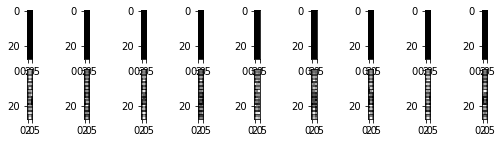

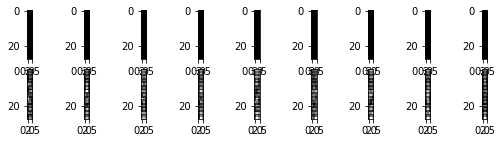

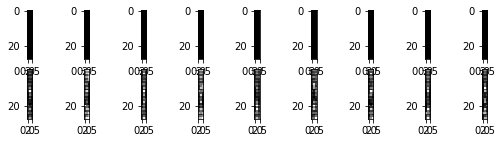

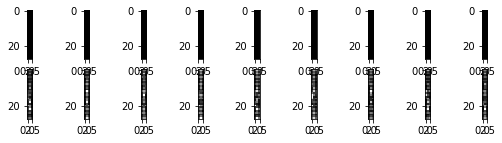

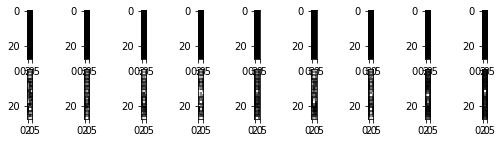

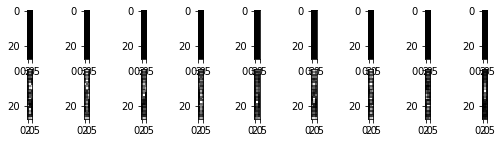

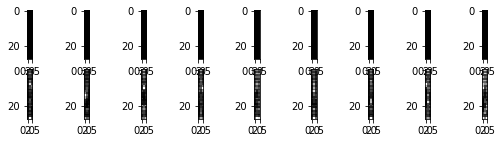

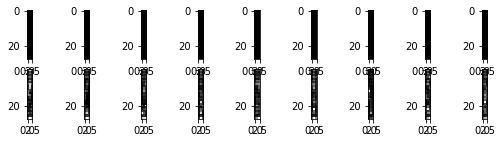

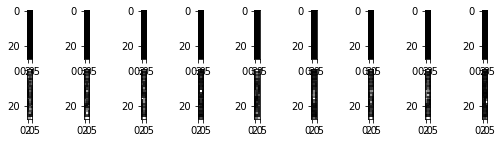

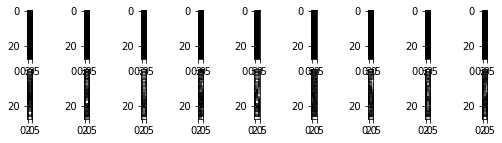

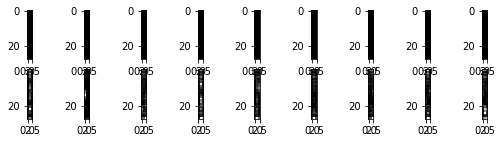

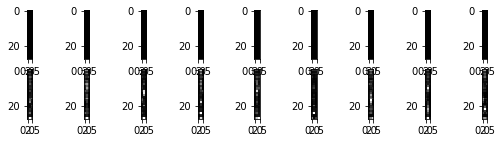

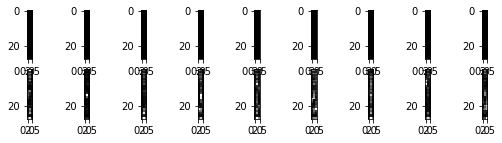

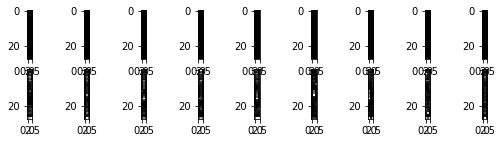

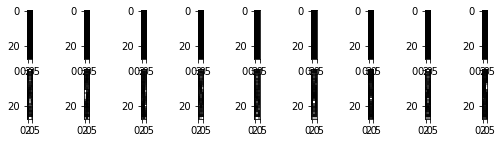

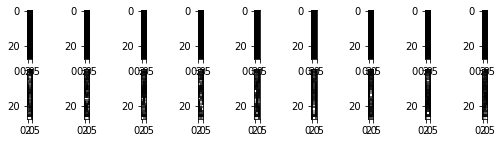

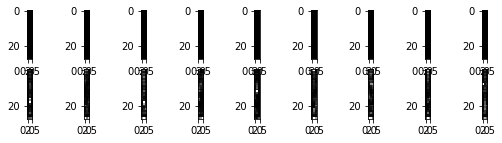

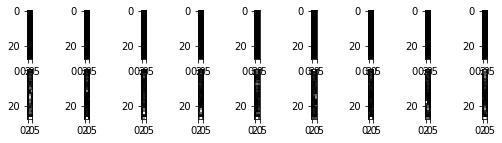

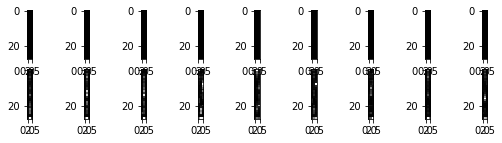

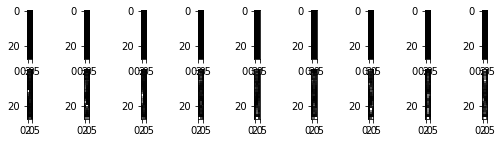

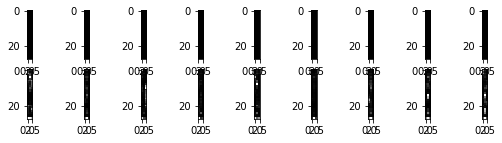

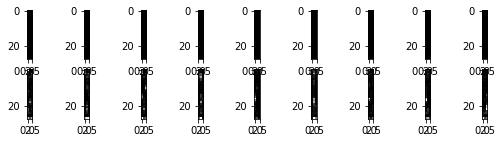

<Figure size 648x144 with 0 Axes>

In [ ]:
if train_outputs:
    for k in range(0, EPOCHS, 4):
        plt.figure(figsize=(9, 2))
        #plt.gray()

        imgs = train_outputs[k][1].reshape(-1, 28, 28, 3).detach().cpu().numpy()
        print(imgs.shape)
        recon = train_outputs[k][2].reshape(-1, 28, 28, 3).detach().cpu().numpy()

        for i, item in enumerate(imgs):
            if i >= 9:
                break
            plt.subplot(2, 9, i + 1)
            plt.imshow(item[0])

        for i, item in enumerate(recon):
            if i >= 9:
                break
            plt.subplot(2, 9, 9 + i + 1)
            plt.imshow(item[0])

In [ ]:
# run the model on the test set
test_outputs, test_labels = generate_test_images(model, test_loader, device)

435


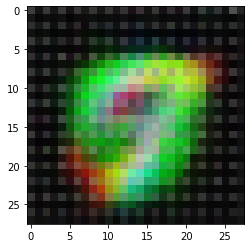

In [ ]:
k = 4
print(test_labels[k])
plt.imshow(test_outputs[k])

In [ ]:
verification_net = VerificationNet()

In [ ]:
predictability, accuracy = verification_net.check_predictability(test_outputs, test_labels, tolerance=0.5)
coverage = verification_net.check_class_coverage(test_outputs, tolerance=0.5)
print(f"Predictability: {predictability} \nAccuracy: {accuracy} \nCoverage: {coverage}")

Predictability: 0.091 
Accuracy: 0.0079 
Coverage: 0.039


In [ ]:
# decoder = model.decoder
# num_samples = 36
# z = np.random.rand(num_samples, 16)

# generative_out = decoder(torch.from_numpy(z).float().to(device)).reshape(-1, 28, 28, 1).detach().cpu().numpy()
# generative_out_tile = generative_out.squeeze()
# tiled_image = tile_images(generative_out_tile, show=True)

# generative_predictability, generative_accuracy = verification_net.check_predictability(generative_out, tolerance=0.8)
# generative_coverage = verification_net.check_class_coverage(generative_out, tolerance=0.8)
# print(f"Predictability: {generative_predictability} \nAccuracy: {generative_accuracy} \nCoverage: {generative_coverage}")